# Recommender System

[Yahoo! Music User Ratings of Musical Artists, version 1.0 (423 MB)](http://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=1)
    This dataset represents a snapshot of the Yahoo! Music community's preferences for various musical artists. The dataset contains over ten million ratings of musical artists given by Yahoo! Music users over the course of a one month period sometime prior to March 2004. Users are represented as meaningless anonymous numbers so that no identifying information is revealed. The dataset may be used by researchers to validate recommender systems or collaborative filtering algorithms. The dataset may serve as a testbed for matrix and graph algorithms including PCA and clustering algorithms. The size of this dataset is 423 MB.

From the readme.txt:
```
This dataset consists of two files:
1. ydata-ymusic-user-artist-ratings-v1_0.txt
2. ydata-ymusic-artist-names-v1_0.txt

The content of the two files are as follows:

=====================================================================

(1) "ydata-ymusic-user-artist-ratings-v1_0.txt" contains user ratings
    of music artists. It contains 11,557,943 ratings of 98,211 artists
    by 1,948,882 anonymous users. The format of each line of the file
    is: anonymous_user_id (TAB) artist_id (TAB) rating. The ratings
    are integers ranging from 0 to 100, except 255 (a special case
    that means "never play again").

Snippet:
1       1000125 90
1       1006373 100
1       1006978 90
1       1007035 100
1       1007098 100

====================================================================

(2) "ydata-ymusic-artist-names-v1_0.txt" contains the artist_id and
    name of each musical artist.

Snippet:
-100    Not Applicable
-99     Unknown Artist
1000001 Bobby "O"
1000002 Jimmy "Z"
1000003 '68 Comeback
```



In [17]:
import re
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
import psycopg2
conn = psycopg2.connect("dbname=ymusic_data user=btq")
# Open a cursor to perform database operations
cur = conn.cursor()
# Query the database and obtain data as Python objects
cur.execute("SELECT * FROM ym_ratings WHERE uid <= 3 and uid > 1;")
cur.fetchall()

[(2, 1004623, 0),
 (2, 1018143, 0),
 (2, 1040071, 90),
 (2, 1053438, 90),
 (2, 1098087, 90),
 (2, 1098636, 90),
 (3, 1006316, 90)]

In [72]:
import pandas.io.sql as psql
uid = 2
qu_string = "SELECT * FROM ym_ratings WHERE uid = %i ;" % uid
user_df = psql.read_sql(qu_string, conn)
user_df

,uid,aid,rating
0,2,1004623,0
1,2,1018143,0
2,2,1040071,90
3,2,1053438,90
4,2,1098087,90
5,2,1098636,90


In [75]:
qa_string = "SELECT * FROM ym_artist WHERE aid = %s" % " OR aid = ".join([str(a) for a in user_df.aid.unique()])
artists_df = psql.read_sql(qa_string,conn)
artists_df

,aid,name,num_ratings,avg_rating
0,1004623,Case,29761,60.4288
1,1018143,Mint Condition,33387,50.2580
2,1040071,Ja Rule,337804,68.6612
3,1053438,Musiq,109104,63.0521
4,1098087,Ashanti,2689,89.5288
5,1098636,Baby,35649,66.8373


In [13]:
uid = 2
qstring = 'SELECT uid, aid, rating FROM ym_ratings WHERE aid IN (SELECT aid FROM ym_ratings WHERE uid = %i) ;' % uid
data_df = psql.read_sql(qstring, conn)
data_df.head()

,uid,aid,rating
0,827392,1040071,100
1,827395,1040071,90
2,827396,1040071,90
3,827402,1040071,90
4,827405,1040071,90


In [ ]:
#convert 255 to 0

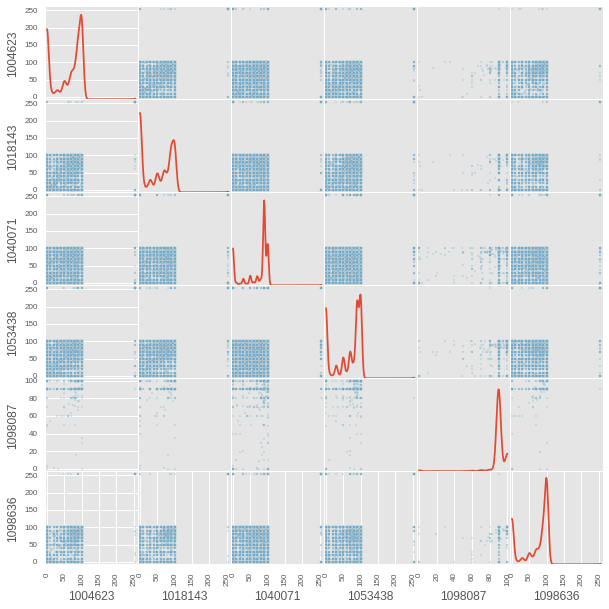

In [78]:
pivoted_df = pd.pivot_table(data_df,values='rating',columns=['aid'],index=['uid'],fill_value=None)
pd.tools.plotting.scatter_matrix(pivoted_df, alpha=0.2, figsize=(10,10), diagonal='kde');


In [30]:
match_counts = data_df['uid'].value_counts()
print match_counts.value_counts()
match_all = match_counts[match_counts == 6]
match_all.index

1    283753
2     65647
3     23981
4     11258
5      3176
6        82
Name: uid, dtype: int64


Int64Index([1473870, 1715309,  102565, 1073763,  427575, 1301981, 1746805,
             855558, 1848957, 1428947,  507958,  888586,  835513, 1019500,
            1699192,  265617, 1728147, 1869153,  585365,  722908, 1655700,
            1740247,   89601,  128685,  864094,  788951, 1539615,  745087,
              45546, 1656418, 1709192,  747863,  565056,  453651,  354789,
            1726981,  569925, 1658020, 1928206,  184646, 1652817,  803728,
             998007, 1493594, 1810795, 1891058,  670103, 1235501,  582817,
            1939833, 1479167,  686491,  140933,  898471, 1935427,  959663,
             654010, 1940848, 1270136, 1096108,  756497, 1827793, 1882429,
            1740291, 1056287, 1260146, 1040274, 1146588, 1542898,  493864,
                  2,   99795, 1151411,  991153, 1276960, 1385900,  379893,
             823019, 1729070, 1650166, 1185739, 1937099],
           dtype='int64')

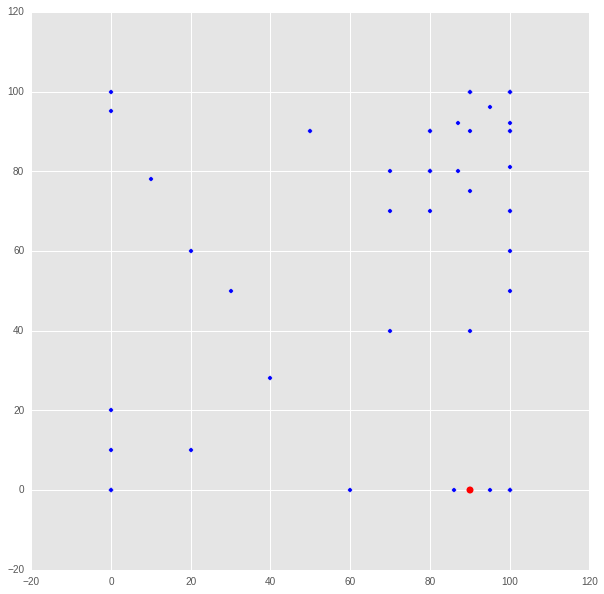

In [48]:
fig,ax = plt.subplots(figsize=(10,10))
plot_data_df = data_df[data_df['uid'].isin(match_all.index)]
plt.scatter(plot_data_df[plot_data_df['aid']==1040071]['rating'].values,plot_data_df[plot_data_df['aid']==1004623]['rating'].values,zorder=1)
plt.plot(df[df['aid']==1040071]['rating'],df[df['aid']==1004623]['rating'],'ro',zorder=2)
plt.show()

In [ ]:
axes = pd.tools.plotting.scatter_matrix(data_df, color="blue")

In [2]:
d = defaultdict(lambda: defaultdict(int))
tic = timeit.default_timer()
with open('data/ydata-ymusic-user-artist-ratings-v1_0_2002.txt') as infile:
    for line in infile:
        #print line
        vals = re.split('\t',line)
        #print vals
        d[vals[0]][vals[1]]= int(vals[2].strip())
toc=timeit.default_timer()
print toc - tic
print d['1']         

0.241866111755
defaultdict(<type 'int'>, {'1008916': 100, '1042768': 100, '1016885': 100, '1024496': 100, '1036157': 90, '1033451': 100, '1007035': 100, '1041557': 90, '1045525': 100, '1098798': 90, '1017874': 100, '1020778': 100, '1007723': 100, '1007098': 100, '1020524': 100, '1000125': 90, '1047584': 100, '1006978': 90, '1020560': 100, '1016419': 100, '1019522': 100, '1024006': 100, '1016470': 100, '1006373': 100, '1024759': 100, '1017881': 100, '1043712': 100, '1008659': 100, '1037847': 100, '1029612': 100, '1024635': 100, '1034801': 100, '1045024': 100, '1021623': 100, '1012809': 70, '1014635': 100, '1016522': 100, '1053507': 90, '1024015': 100, '1019512': 100})
